In [309]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import time
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FunctionTransformer, make_pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from scipy.stats import randint

# EXAMEN

## EJERCICIO 1

Carga el conjunto de datos Iris (el de las flores según la anchura y la altura del pétalo y del sépalo) desde scikit-learn (se ha hecho en algún ejercicio). HECHO


Explora los datos visualmente utilizando gráficos: representa la distribución de cada variable (todas las de X e y), diagramas de cajas de cada variable (todas las de X) y la matriz de correlaciones para entender las relaciones entre las características. ¿Qué puedes deducir? HECHO

Divide el conjunto de datos en entrenamiento y prueba, estratificando por el tipo de flor. HECHO

Prepara los datos mediante una pipeline. HECHO

Entrena y evalúa un clasificador Random Forest utilizando validación cruzada. ¿Qué métrica has usado para evaluar el modelo y por qué? ¿Cuál es el mejor y el peor error que consigues? 

Optimiza el número de árboles, ¿cuál es el mejor valor?

Evalúa el rendimiento del modelo optimizado en el conjunto de prueba.

Guarda el modelo en un fichero y cárgalo desde un fichero .py que pida 4 datos para una nueva flor (anchura del pétalo, longitud del pétalo, anchura del sépalo y longitud del sépalo) y prediga de que clase es la flor (quiero que me de un nombre, no un número y hay que controlar las excepciones).

In [310]:
# Obtencion de datos
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target


In [311]:
data_iris=np.column_stack((X,y))
df_iris = pd.DataFrame(data=data_iris)
column_names = list(X.columns) + ['tipo']
df_iris = pd.DataFrame(data=data_iris, columns=column_names)

In [312]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   tipo               150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


In [313]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),tipo
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


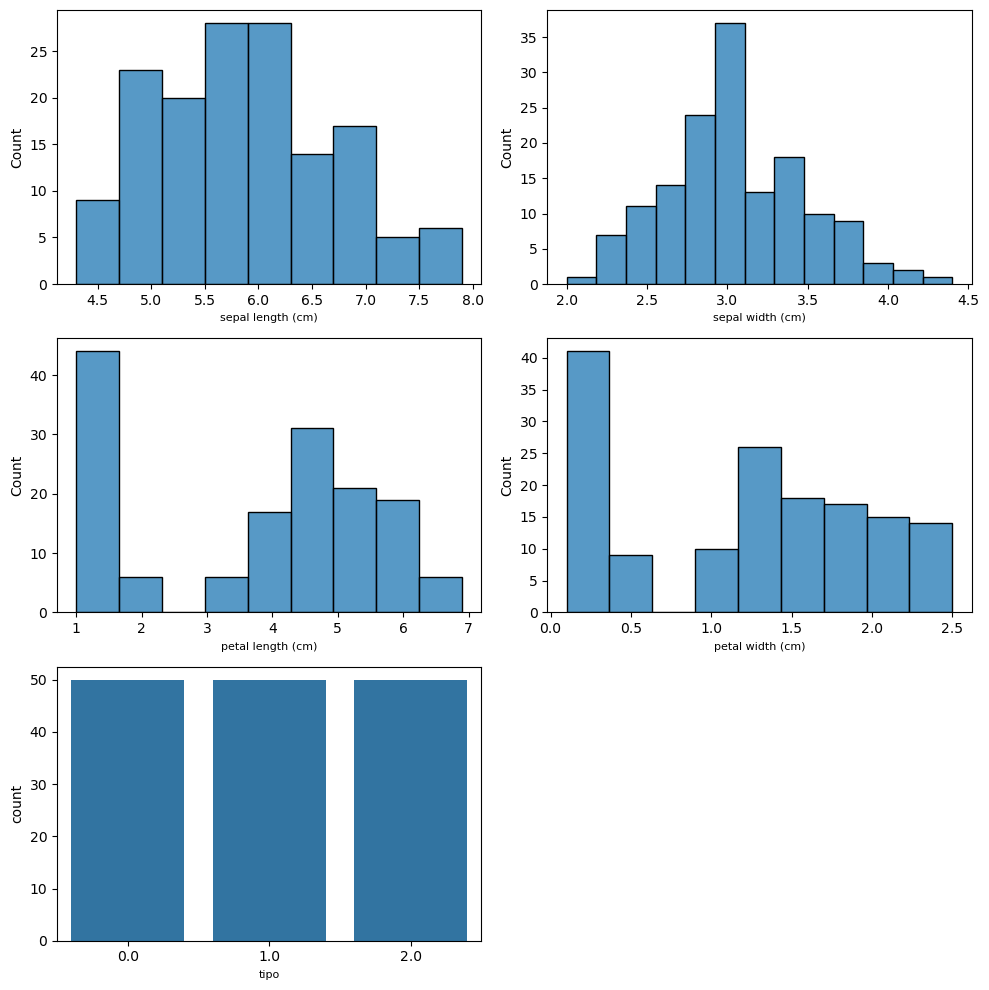

In [314]:
Xs=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','tipo']
plt.figure(figsize=(10,10))
for contador in range(5):
    plt.subplot(3,2,contador+1)
    plt.xlabel(Xs[contador],fontsize=8)
    if contador<4:
        sns.histplot(df_iris,x=Xs[contador],legend=True)
    else:
        sns.countplot(df_iris,x=Xs[contador],legend=None)


plt.tight_layout()
plt.show()


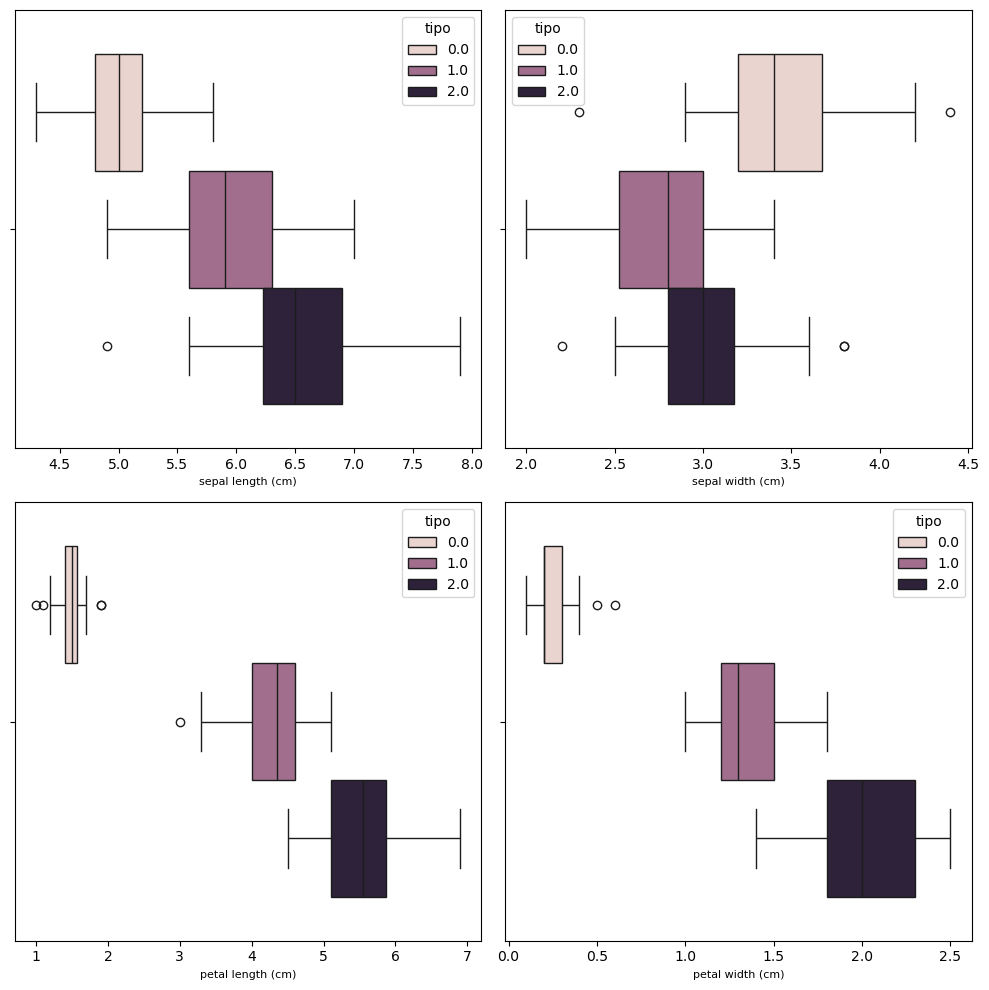

In [315]:
Xs=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','tipo']
plt.figure(figsize=(10,10))
for contador in range(4):
    plt.subplot(2,2,contador+1)
    plt.xlabel(Xs[contador],fontsize=8)
    sns.boxplot(df_iris,x=Xs[contador],hue='tipo',legend=True)
    


plt.tight_layout()
plt.show()

In [316]:
# Con los diagramas de cajas se puede apreciar de manera más obvia
# las dimensiones de los petales y los sepalos cambia sustancialmente según el tipo
df_iris.groupby('tipo').mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
tipo,,,,
0.0,5.006,3.428,1.462,0.246
1.0,5.936,2.770,4.260,1.326
2.0,6.588,2.974,5.552,2.026


In [317]:
df_iris["tipo"].value_counts()

tipo
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64

In [318]:
# Es una distribución balanceada, habrá que estratificar los datos segun el tipo

In [319]:
corr_matrix = df_iris.corr(numeric_only=True).abs()
target_corr=corr_matrix['tipo'].sort_values(ascending=False)
target_corr

tipo                 1.000000
petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)     0.426658
Name: tipo, dtype: float64

In [320]:
corr_matrix.style.background_gradient()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),tipo
sepal length (cm),1.000000,0.117570,0.871754,0.817941,0.782561
sepal width (cm),0.117570,1.000000,0.428440,0.366126,0.426658
petal length (cm),0.871754,0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,0.366126,0.962865,1.000000,0.956547
tipo,0.782561,0.426658,0.949035,0.956547,1.000000


In [321]:
# Separamos los datos estratificando por tipo
df_iris_train, df_iris_test = train_test_split(df_iris, test_size=0.15, stratify=df_iris['tipo'], random_state=17)

# Separamos la variable dependiente de las independientes
df_iris_train_y = df_iris_train['tipo'].copy()
df_iris_train_x = df_iris_train.drop('tipo',axis=1)

df_iris_test_y = df_iris_test['tipo'].copy()
df_iris_test_x = df_iris_test.drop('tipo',axis=1)


In [322]:
# Dado que los datos solo requieren de una estandarización no seria necesario hacer una pipeline ya 
# que es posible estandarizar directamente desde la definición del modelo, pero como es posible que en 
# el futuru entren tuplas con valores nulos haremos una pipeline para cubirnos de ese caso


pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

transformar = ColumnTransformer([
        ("pipeline", pipeline, ['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']),
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline=make_pipeline(transformar)

prep_array = pipeline.fit_transform(df_iris)

feature_names = pipeline.get_feature_names_out()

df_iris_adapt = pd.DataFrame(prep_array, columns=feature_names)

df_iris_adapt.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),tipo
0,-0.900681,1.019004,-1.340227,-1.315444,0.0
1,-1.143017,-0.131979,-1.340227,-1.315444,0.0
2,-1.385353,0.328414,-1.397064,-1.315444,0.0
3,-1.506521,0.098217,-1.283389,-1.315444,0.0
4,-1.021849,1.249201,-1.340227,-1.315444,0.0


In [323]:
modelo_RF=make_pipeline(transformar,RandomForestClassifier(n_estimators=100,random_state=17))
#modelo_RF.fit(df_iris_train_x,df_iris_train_y)


cv_scores_acc = cross_val_score(modelo_RF, df_iris_train_x, df_iris_train_y,scoring='accuracy') 
cv_scores_nmsq = -cross_val_score(modelo_RF, df_iris_train_x, df_iris_train_y,scoring='neg_mean_squared_error') 
print("Puntuaciones de Validacion cruzada acc:",cv_scores_acc)
print("Puntuaciones de Validacion cruzada nmsq:",cv_scores_nmsq)
print("Puntuación media de validación cruzada acc:",np.mean(cv_scores_acc))
print("Puntuación media de validación cruzada nmsq:",np.mean(cv_scores_nmsq))


Puntuaciones de Validacion cruzada acc: [1.         0.88461538 0.92       0.96       0.96      ]
Puntuaciones de Validacion cruzada nmsq: [0.         0.11538462 0.08       0.04       0.04      ]
Puntuación media de validación cruzada acc: 0.944923076923077
Puntuación media de validación cruzada nmsq: 0.05507692307692308


In [324]:
# A vista de estos resultados parece que accuracy nos va a dar bastante mejores resultados.

In [325]:
# Optmizacion del modelo Numero de arboles
full_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("random_forest", RandomForestClassifier(n_estimators=100,random_state=17)),
])
param_dist = {
    'random_forest__n_estimators': randint(10, 200),
}


rndm_search = RandomizedSearchCV(full_pipeline, param_dist, cv=3, scoring='accuracy',n_jobs=-1)
rndm_search.fit(df_iris_train_x, df_iris_train_y)
print("Mejores parámetros:", rndm_search.best_params_)

Mejores parámetros: {'random_forest__n_estimators': 34}


In [326]:
modelo_RF_opti=rndm_search.best_estimator_

# predicciones

predic_y_test_RF_opti = modelo_RF_opti.predict(df_iris_test_x)
test_prec_RF_opti = accuracy_score(df_iris_test_y,predic_y_test_RF_opti)

print("Precision del modelo optimizado:{}".format(test_prec_RF_opti))

Precision del modelo optimizado:0.9565217391304348


In [327]:
joblib.dump(modelo_RF_opti, "./iris_model.pkl")

['./iris_model.pkl']

## EJERCICIO 2

En este ejercicio, trabajarás con un conjunto de datos de pruebas creados (ejercicio2.csv). 

Tu objetivo es construir un modelo de regresión que pueda predecir con precisión la variable dependiente y a partir de las variables independientes x1 y x2. 

Deberás:
* Cargar los datos
* Visualizar gráficamente los datos (x1 respecto a y e x2 respecto a y)
* Dividir los datos en conjunto de entrenamiento y pruebas
* Probar diferentes modelos de regresión polinómica (PolynomialFeatures + ), hasta ver cuál es el mejor degree (y explicarlo gráficamente y por medida del error en los conjuntos de entrenamiento y pruebas), no hace falta que uses validación cruzada. ¿Qué medición has usado para evaluar el modelo y por qué? ¿cuál es el mejor degree?
* Probar ahora con Elastic Net, optimizando los hiperparámetros con búsqueda exhaustiva, ¿ha mejorado con esta regularización? ¿cuáles son los mejores datos para los hiperparámetros?

Pista para hacer la gráfica:

´´´´´´

    degrees = [1, 2, 3, 4, 5]
    train_errors = []
    test_errors = []

    for degree in degrees:
        model = Pipeline([
            XXX
        ])
        model.fit(XXX)

        y_train_pred = model.predict(XXX)
        y_test_pred = model.predict(XXX)
        train_error= XXX #medir el error en el conjunto de entrenamiento
        test_error= XXX #medir el error en el conjunto de test
        train_errors.append(train_error)
        test_errors.append(test_error)
        print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_errors, label='Train Error')
    plt.plot(degrees, test_errors, label='Test Error')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Mean Squared Error')
    plt.title('Error vs. Degree of Polynomial')
    plt.legend()
    plt.show()

´´´´´´

In [328]:
df_ejer2 = pd.read_csv("ejercicio2.csv")

In [329]:
df_ejer2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   y       2000 non-null   float64
dtypes: float64(3)
memory usage: 47.0 KB


In [330]:
df_ejer2.describe()

,x1,x2,y
count,2000.000000,2000.000000,2000.000000
mean,0.036358,-0.054283,48.740011
std,2.949828,2.867048,277.069557
min,-4.996327,-4.999276,-742.189025
25%,-2.507467,-2.430828,-121.433051
50%,0.011938,-0.170823,17.398991
75%,2.668045,2.467225,215.989595
max,4.998086,4.999640,1062.625985


In [331]:
df_ejer2.head()

,x1,x2,y
0,0.488135,3.115185,-91.197936
1,2.151894,-0.239160,-44.928270
2,1.027634,0.231560,-5.347793
3,0.448832,-2.494794,78.026649
4,-0.763452,1.050430,2.176875


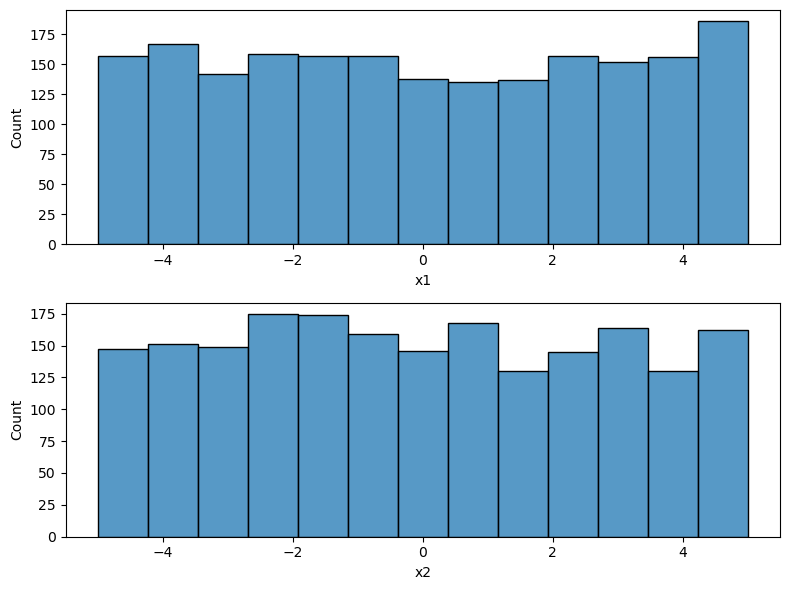

In [332]:

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
sns.histplot(df_ejer2,x='x1',legend=False)
plt.subplot(2,1,2)
sns.histplot(df_ejer2,x='x2',legend=False)

plt.tight_layout()
plt.show()

In [333]:
df_ejer2_train, df_ejer2_test = train_test_split(df_ejer2, test_size=0.15, random_state=17)

df_ejer2_train_y = df_ejer2_train['y'].copy()
df_ejer2_train_x = df_ejer2_train.drop('y',axis=1)

df_ejer2_test_y = df_ejer2_test['y'].copy()
df_ejer2_test_x = df_ejer2_test.drop('y',axis=1)

Polinomio de grado 1
Puntuacion con el conjunto de entranamiento 0.8345771065531848
Puntuacion con el conjunto de prueba 0.8438027755592414
Grado: 1, error entrenamiento:13010.594874040617 , error test: 10907.868758876026
--------------------
Polinomio de grado 2
Puntuacion con el conjunto de entranamiento 0.8481240110034277
Puntuacion con el conjunto de prueba 0.8581342924989315
Grado: 2, error entrenamiento:12122.833932707703 , error test: 9907.04235844893
--------------------
Polinomio de grado 3
Puntuacion con el conjunto de entranamiento 0.9986963464581848
Puntuacion con el conjunto de prueba 0.9986011884717145
Grado: 3, error entrenamiento:104.0573961713999 , error test: 97.68453071794676
--------------------
Polinomio de grado 4
Puntuacion con el conjunto de entranamiento 0.9987005253135509
Puntuacion con el conjunto de prueba 0.9986283391803584
Grado: 4, error entrenamiento:106.2613748638554 , error test: 95.78848955806642
--------------------
Polinomio de grado 5
Puntuacion co

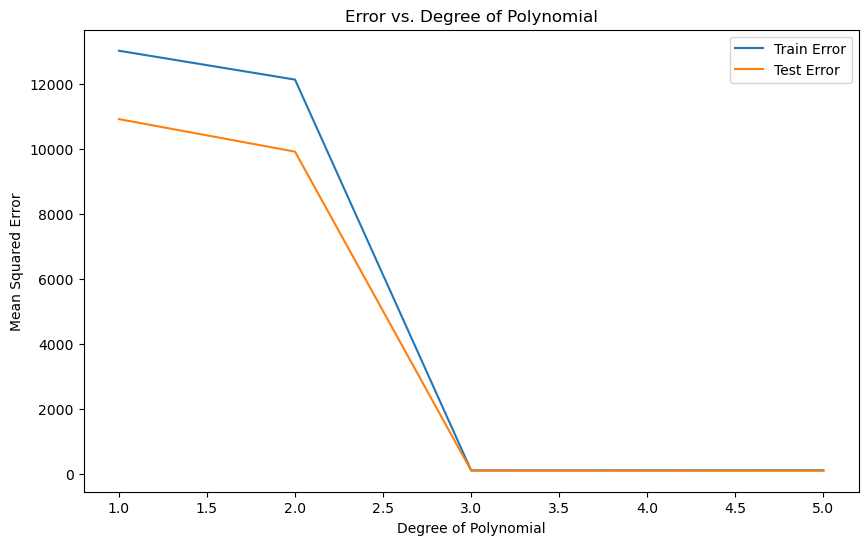

In [334]:
df_ejer2_train_y = df_ejer2_train['y'].copy()
df_ejer2_train_x = df_ejer2_train.drop('y',axis=1)

df_ejer2_test_y = df_ejer2_test['y'].copy()
df_ejer2_test_x = df_ejer2_test.drop('y',axis=1)

degrees = [1, 2, 3, 4, 5]
train_errors = []
test_errors = []



for degree in degrees:
    poly = Pipeline([
    ("s_imput", SimpleImputer(strategy='mean')),
    ("Polynomia_Features", PolynomialFeatures(degree=degree)),
    ])
    
    model.fit(df_ejer2_train_x,df_ejer2_train_y)
    
    df_ejer2_train_adapt_x = poly.fit_transform(df_ejer2_train_x)
    df_ejer2_test_adapt_x = poly.fit_transform(df_ejer2_test_x)

    model=LinearRegression()

    print("Polinomio de grado",degree)
    model.fit(df_ejer2_train_adapt_x,df_ejer2_train_y)
    print("Puntuacion con el conjunto de entranamiento",model.score(df_ejer2_train_adapt_x,df_ejer2_train_y))
    model.fit(df_ejer2_test_adapt_x,df_ejer2_test_y)
    print("Puntuacion con el conjunto de prueba",model.score(df_ejer2_test_adapt_x,df_ejer2_test_y))
    
    y_pred_train=model.predict(df_ejer2_train_adapt_x)
    y_pred_test=model.predict(df_ejer2_test_adapt_x)


    train_error= mean_squared_error(df_ejer2_train_y,y_pred_train) #medir el error en el conjunto de entrenamiento
    test_error= mean_squared_error(df_ejer2_test_y,y_pred_test) #medir el error en el conjunto de test
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))
    print("--------------------")

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error')
plt.plot(degrees, test_errors, label='Test Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Degree of Polynomial')
plt.legend()
plt.show()





In [335]:
# El polinomio de grado 3 parece darnos los mejores resultados tanto de error como de puntuaciones

In [336]:
# df_ejer2_train_y
# df_ejer2_train_x

# df_ejer2_test_y 
# df_ejer2_test_x 

modelo_EN = ElasticNet()
alpha_values = np.logspace(-2, 3, num=50)
param_grid = {
    'alpha': [0.1,0.5,1,5,10],           
    'l1_ratio': [0.0,0.1,0.5,0.7,1],                                                          
}

# Configurar la búsqueda en rejilla
grid_search = GridSearchCV(
    estimator=modelo_EN,
    param_grid=param_grid,   
    scoring="neg_mean_squared_error",      
    cv=5,                   
    verbose=1,               
    n_jobs=-1,               
)

# Realizar la búsqueda en rejilla en el conjunto de entrenamiento
grid_search.fit(df_ejer2_train_x, df_ejer2_train_y)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores hiperparámetros: {'alpha': 0.1, 'l1_ratio': 1}


/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.265e+06, tolerance: 1.064e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.283e+06, tolerance: 1.038e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

In [337]:
best_model = grid_search.best_estimator_
y_predicciones_ejer2_opti = best_model.predict(df_ejer2_test_x)



rmse_test_ejer2_opti = np.sqrt(mean_squared_error(df_ejer2_test_y, y_predicciones_ejer2_opti))
print("RMSE con el modelo óptimo:",rmse_test_ejer2_opti)

RMSE con el modelo óptimo: 105.03115730260272


## EJERCICIO 3

Queremos predecir la calidad del vino (quality) a partir del resto de características.

Carga el conjunto de datos winequality.csv, explora los datos y divide el conjunto de datos en entrenamiento y pruebas (10% para las pruebas).

Crea una pipeline para preparar los datos y aplicar un algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Crea una pipeline para preparar los datos y aplicar PCA que explique al menos el 95% de la varianza, aplica esta pipeline al conjunto de entrenamiento y al conjunto de pruebas.

Muestra cuantas dimensiones tenías al principio y cuantas después de aplicar PCA.

Aplica a los datos obtenido de aplicar PCA el algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Compara el error y el tiempo empleado en los dos modelos (sin pca y con pca) e interpreta el resultado.


In [338]:
df_wine = pd.read_csv("winequality.csv")

In [339]:
# No se si era voluntario, pero al tener los valores separados por ; en lugar de ,
# el dataframe se creaba catastroficamente mal, he sustituido con VSCode todos los ; con , y va 

In [340]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [341]:
df_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [342]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [343]:
corr_matrix = df_wine.corr(numeric_only=True).abs()
target_corr=corr_matrix['quality'].sort_values(ascending=False)
target_corr

quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

In [344]:
# Vista su poca relación nos cargaremos residual sugar.

In [345]:
corr_matrix.style.background_gradient()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.256131,0.671703,0.114777,0.093705,0.153794,0.113181,0.668047,0.682978,0.183006,0.061668,0.124052
volatile acidity,0.256131,1.000000,0.552496,0.001918,0.061298,0.010504,0.076470,0.022026,0.234937,0.260987,0.202288,0.390558
citric acid,0.671703,0.552496,1.000000,0.143577,0.203823,0.060978,0.035533,0.364947,0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,0.265026,0.371260,0.221141,0.128907
free sulfur dioxide,0.153794,0.010504,0.060978,0.187049,0.005562,1.000000,0.667666,0.021946,0.070377,0.051658,0.069408,0.050656
total sulfur dioxide,0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,0.066495,0.042947,0.205654,0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,0.021946,0.071269,1.000000,0.341699,0.148506,0.496180,0.174919
pH,0.682978,0.234937,0.541904,0.085652,0.265026,0.070377,0.066495,0.341699,1.000000,0.196648,0.205633,0.057731
sulphates,0.183006,0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,0.196648,1.000000,0.093595,0.251397


In [346]:
df_wine_train, df_wine_test = train_test_split(df_wine, test_size=0.1, random_state=17)

df_wine_train_y = df_wine_train['quality'].copy()
df_wine_train_x = df_wine_train.drop('quality',axis=1)

df_wine_test_y = df_wine_test['quality'].copy()
df_wine_test_x = df_wine_test.drop('quality',axis=1)



In [347]:
df_wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [348]:
pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
transformar = ColumnTransformer([
        ("pipeline", pipe, ['fixed acidity','volatile acidity','citric acid','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']),
        ("drop_columns", 'drop', ["residual sugar"])
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline=make_pipeline(transformar)

prep_array = pipeline.fit_transform(df_wine)

feature_names = pipeline.get_feature_names_out()

df_wine_adapt = pd.DataFrame(prep_array, columns=feature_names)

df_wine_adapt.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0
1,-0.298547,1.967442,-1.391472,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5.0
2,-0.298547,1.297065,-1.186070,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5.0
3,1.654856,-1.384443,1.484154,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6.0
4,-0.528360,0.961877,-1.391472,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0


In [349]:
modelo_SVC=make_pipeline(transformar,SVC(random_state=17, max_iter=1000))
print("Entrenando modelo_SVC")
%time modelo_SVC.fit(df_wine_train_x,df_wine_train_y)

Entrenando modelo_SVC
CPU times: user 123 ms, sys: 4.16 ms, total: 127 ms
Wall time: 127 ms


/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid', 'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol']),
                                                 ('drop_columns', 'drop',
                                                  ['residual sugar'])],
                                   verbose_feature_names_out=False)),
                ('svc', SVC(max_iter=1000, random_state=17))])

In [350]:
modelo_SVC_pred= modelo_SVC.predict(df_wine_test_x)
exactitud_SVC = accuracy_score(df_wine_test_y, modelo_SVC_pred)
print("Exactitud del modelo SVC con el conjunto de prueba:",exactitud_SVC)

Exactitud del modelo SVC con el conjunto de prueba: 0.65625


In [355]:
pca = PCA(n_components=0.95)

pipePCA = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    PCA(n_components=0.95)
    
)
transformarPCA = ColumnTransformer([
        ("pipeline", pipePCA, ['fixed acidity','volatile acidity','citric acid','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']),
        ("drop_columns", 'drop', ["residual sugar"]),
        ("quality", 'passthrough', ["quality"])
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipelinePCA=make_pipeline(transformarPCA)

prep_array_PCA = pipelinePCA.fit_transform(df_wine)

feature_names = pipelinePCA.get_feature_names_out()

df_wine_adapt_PCA = pd.DataFrame(prep_array_PCA, columns=feature_names)

df_wine_adapt_PCA.head()


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,quality
0,-1.579816,0.568078,-1.732398,0.082881,-0.926088,-0.113545,-0.164216,0.000785,5.0
1,-0.864401,1.929410,-0.756157,0.426699,0.686228,0.973338,1.020112,-0.514987,5.0
2,-0.750356,0.996979,-1.078094,0.353237,0.310671,0.415510,0.736394,-0.081701,5.0
3,2.444523,-0.027423,0.305346,-1.491981,0.148450,-0.659961,-0.285685,0.083021,6.0
4,-1.579816,0.568078,-1.732398,0.082881,-0.926088,-0.113545,-0.164216,0.000785,5.0


In [ ]:
# No pilla los nombres de las columnas

In [301]:
print("Dimensiones antes del PCA",np.shape(prep_array))
print("Dimensiones depues del PCA",np.shape(prep_array_PCA))

Dimensiones antes del PCA (1599, 11)
Dimensiones depues del PCA (1599, 9)


In [302]:
modelo_SVC_PCA=make_pipeline(transformarPCA,SVC(random_state=17, max_iter=1000))
print("Entrenando modelo_SVC con reduccion PCA")
%time modelo_SVC.fit(df_wine_train_x,df_wine_train_y)

Entrenando modelo_SVC con reduccion PCA
CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 138 ms


/home/iabd/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid', 'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol']),
                                                 ('drop_columns', 'drop',
                                                  ['residual sugar'])],
                                   verbose_feature_names_out=False)),
                ('svc', SVC(max_iter=1000, random_state=17))])

In [356]:
modelo_SVC_PCA_pred_train= modelo_SVC_PCA.predict(df_wine_train_x)
modelo_SVC_PCA_pred_test= modelo_SVC_PCA.predict(df_wine_test_x)
exactitud_SVC_PCA_train = accuracy_score(df_wine_test_y, modelo_SVC_PCA_pred_train)
exactitud_SVC_PCA_test = accuracy_score(df_wine_test_y, modelo_SVC_PCA_pred_test)
print("Exactitud del modelo SVC con reduccion PCA con el conjunto de entrenamiento:",exactitud_SVC_PCA_train)
print("Exactitud del modelo SVC con reduccion PCA con el conjunto de prueba:",exactitud_SVC_PCA_test)

ValueError: columns are missing: {'quality'}

In [ ]:
# Dice que quality no existe, pero está, si no nos diera error simplemente quedaria comparar su precision 
# con la del modelo que no tiene PCA.

## EJERCICIO 4

Una empresa de coches ha sacado un nuevo modelo al mercado. Le ha preguntado a una red social quién ha comprado el producto, recaudando el sexo, la edad y el salario de cada uno de ellos. Ahora queremos construir un modelo que nos permita determinar con estos atributos si la persona comprará el producto o no, para tomar medidas en función de la respuesta para que lo acabe comprando.

Los datos están en el csv

### RECOPILACIÓN Y RECOLECCIÓN DE LOS DATOS

####  OBTENER LOS DATOS

In [358]:
df_coches = pd.read_csv("compras.csv")

#### EXPLORAR LOS DATOS 
Con exhaustividad: datos estadísticos, gráficos, correlaciones... e indicar las deduciones a las que llegas

In [359]:
df_coches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Identificador  400 non-null    int64 
 1   Sexo           400 non-null    object
 2   Edad           400 non-null    int64 
 3   Salario        400 non-null    int64 
 4   Compra         400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [360]:
df_coches.describe()

,Identificador,Edad,Salario,Compra
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [361]:
df_coches.head()

,Identificador,Sexo,Edad,Salario,Compra
0,15624510,Hombre,19,19000,0
1,15810944,Hombre,35,20000,0
2,15668575,Mujer,26,43000,0
3,15603246,Mujer,27,57000,0
4,15804002,Hombre,19,76000,0


In [362]:
corr_matrix = df_coches.corr(numeric_only=True).abs()
target_corr=corr_matrix['Compra'].sort_values(ascending=False)
target_corr

Compra           1.000000
Edad             0.622454
Salario          0.362083
Identificador    0.007120
Name: Compra, dtype: float64

In [371]:
corr_matrix.style.background_gradient()

,Identificador,Edad,Salario,Compra
Identificador,1.000000,0.000721,0.071097,0.007120
Edad,0.000721,1.000000,0.155238,0.622454
Salario,0.071097,0.155238,1.000000,0.362083
Compra,0.007120,0.622454,0.362083,1.000000


In [ ]:
# Esperaba una correlacion mas alta entre compra y salario

In [366]:
df_coches[["Sexo","Compra"]].groupby('Sexo').mean()

,Compra
Sexo,
Hombre,0.336735
Mujer,0.377451


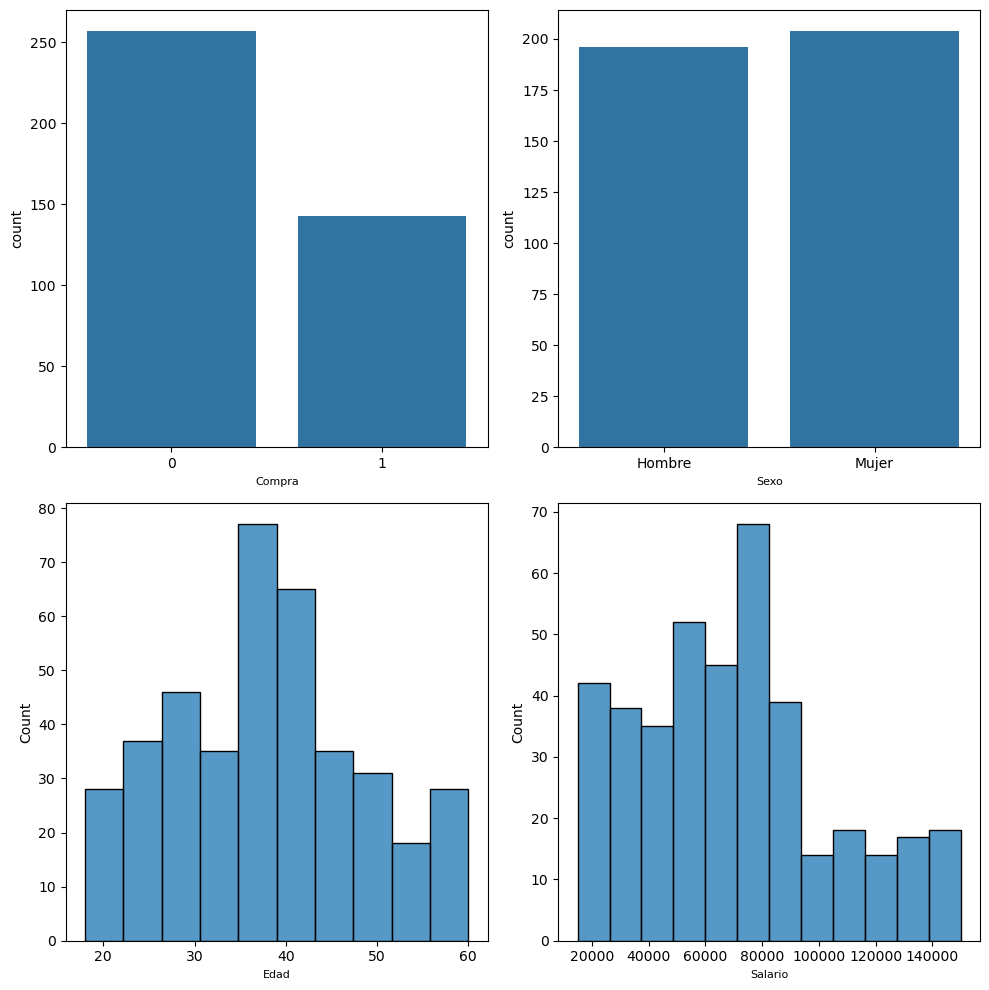

In [370]:
Xs=['Compra','Sexo','Edad','Salario']
plt.figure(figsize=(10,10))
for contador in range(4):
    plt.subplot(2,2,contador+1)
    plt.xlabel(Xs[contador],fontsize=8)
    if contador<2:
        sns.countplot(df_coches,x=Xs[contador],legend=True)
    else:
        sns.histplot(df_coches,x=Xs[contador],legend=None)


plt.tight_layout()
plt.show()

#### DIVIDIR LOS DATOS EN CONJUNTO DE ENTRENAMIENTO Y PRUEBAS

In [ ]:
df_coches_train, df_coches_test = train_test_split(df_coches, test_size=0.15, random_state=17)

df_coches_train_y = df_coches_train['Compra'].copy()
df_coches_train_x = df_coches_train.drop('Compra',axis=1)

df_coches_test_y = df_coches_test['Compra'].copy()
df_coches_test_x = df_coches_test.drop('Compra',axis=1)

KeyError: 'Compra'

#### PREPARAR LOS DATOS
Algunas pistas a tener en cuenta (** esto no quiere decir que sólo haya que hacer esto**):
* No usar las características que no sirven
* Tratar los valores nulos (aunque ahora no haya)
* Edad: primeramente convertir en categórica poniendo las siguientes etiquetas y luego aplicar el cambio que procede en las variables categóricas (es para aplicar los diferentes tipos de transformaciones que hay, no porque tenga mucho sentido).
  * 0-20 --> Rango1
  * 20-30 --> Rango 2
  * 30-40 --> Rango 3
  * 40-50 --> Rango 4
  * 50- --> Rango 5

* Salario: aplicar logaritmo (aunque no tenga una cola larga a la derecha) y luego estandarizar